# MP5: Training Your Diffusion Model!

## Setup environment

In [1]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch # added
from torch import optim # added
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## Visualization helper function

In [2]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    """
    Visualize images as a grid and title the columns with the provided names.

    Args:
        images: (N, C, H, W) tensor of images, where N is (number of rows * number of columns)
        column_names: List of column names for the titles.

    Example usage:
    visualize_images_with_titles(torch.randn(16, 1, 32, 32), ['1', '2', '3', '4'])
    """
    num_images, num_columns = images.shape[0], len(column_names)
    assert num_images % num_columns == 0, 'Number of images must be a multiple of the number of columns.'

    num_rows = num_images // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1, num_rows * 1))

    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i < num_columns:
            ax.set_title(column_names[i % num_columns])

    plt.tight_layout()
    plt.show()


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.op = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding = 1), nn.BatchNorm2d(out_channels), nn.GELU())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.op = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 2, 1), nn.BatchNorm2d(out_channels), nn.GELU())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.op = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1), nn.BatchNorm2d(out_channels), nn.GELU())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.op = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.op = nn.Sequential(nn.ConvTranspose2d(in_channels, in_channels, 7, 7), nn.GELU())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.op = nn.Sequential(Conv(in_channels, out_channels), Conv(out_channels, out_channels))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.op = nn.Sequential(DownConv(in_channels, out_channels), ConvBlock(out_channels, out_channels))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.op = nn.Sequential(UpConv(in_channels, out_channels), ConvBlock(out_channels, out_channels))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)

## Implementing Unconditional UNet

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.op1 = ConvBlock(in_channels, num_hiddens)
        self.op2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.op3 = DownBlock(num_hiddens * 2, num_hiddens * 4)
        self.op4 = Flatten()
        self.op5 = Unflatten(num_hiddens * 4)
        self.op6 = UpBlock(num_hiddens * 4, num_hiddens * 2)
        self.op7 = UpBlock(num_hiddens * 4, num_hiddens)
        self.op8 = nn.Conv2d(2 * num_hiddens, in_channels, 3, padding = 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        e0 = self.op1(x)
        e1 = self.op2(e0)
        e2 = self.op3(e1)
        b = self.op4(e2)
        u = self.op5(b)
        d1 = self.op6(u)
        d1 = torch.cat([d1, e1], 1)
        d2 = self.op7(d1)
        d2 = torch.cat([d2, e0], 1)
        return self.op8(d2)

## Visualizing the noising process

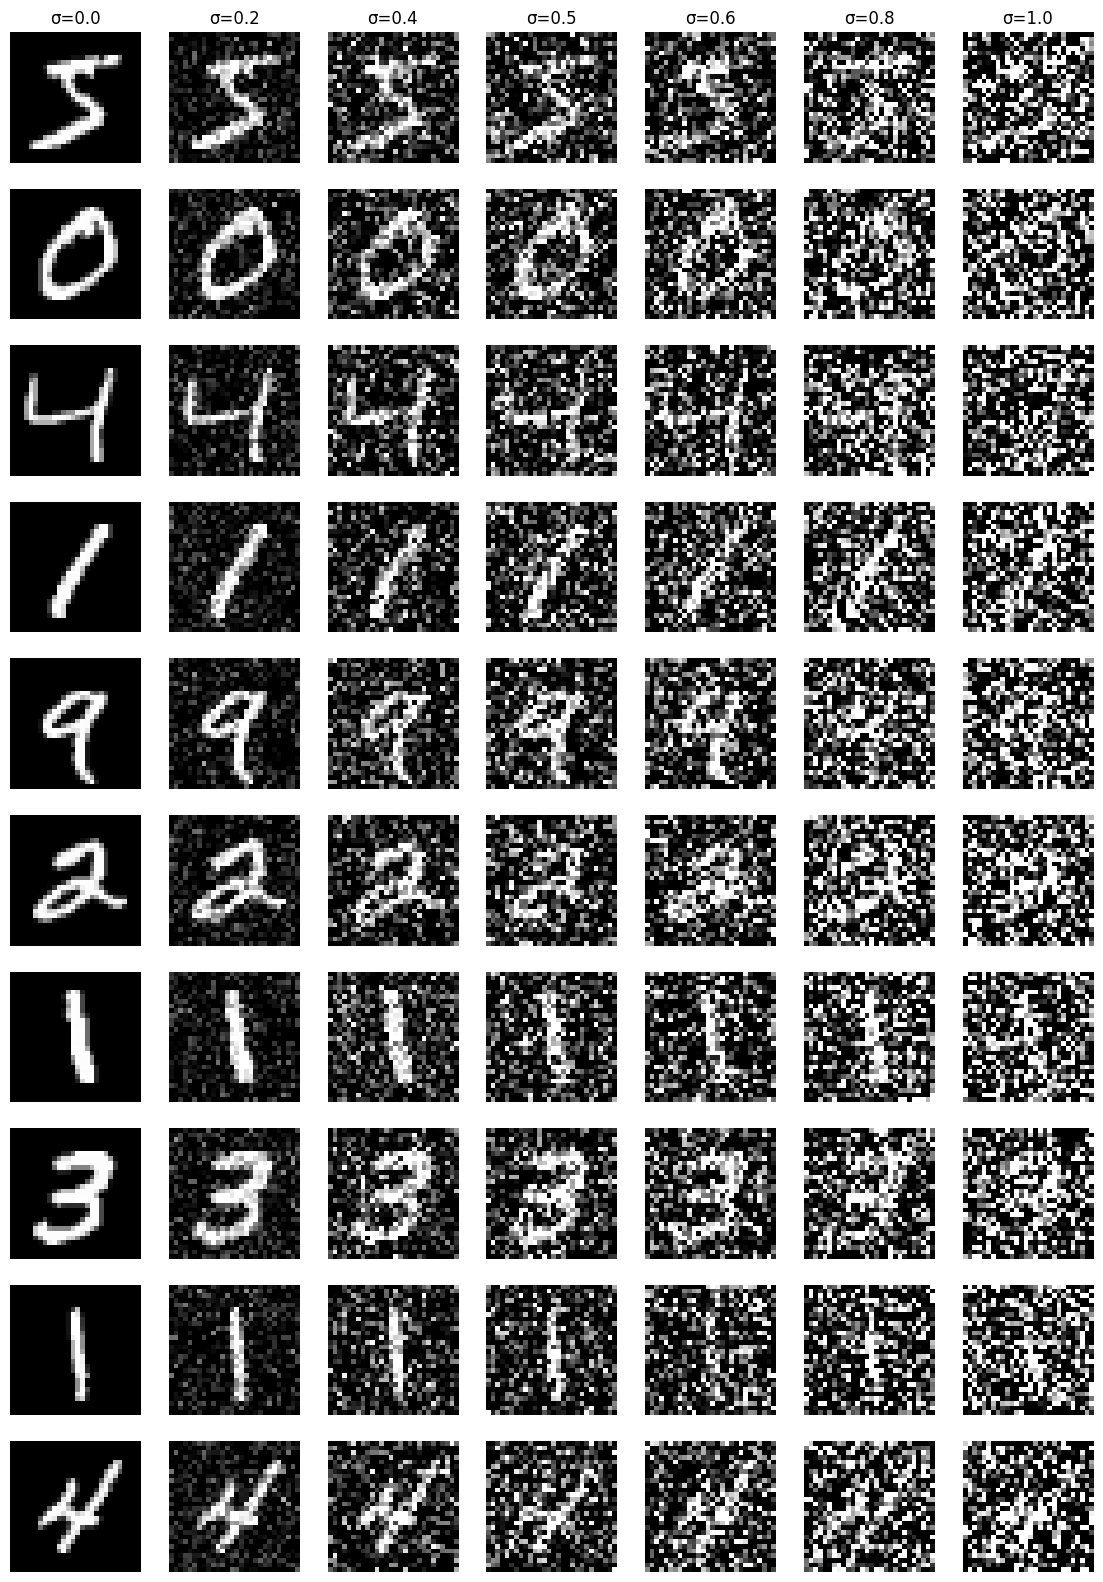

In [5]:
dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
images = [dataset[i][0].squeeze(0) for i in range(10)]
# TODO
l = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
fig, axes = plt.subplots(len(images), len(l), figsize = (2 * len(l), 2 * len(images)))
for i, x in enumerate(images):
    ax = axes[i, 0]
    ax.imshow(x, cmap = "gray", vmin = 0, vmax = 1)
    if i == 0:
        ax.set_title("σ=0.0")
    ax.axis("off")
    for j, y in enumerate(l[1:], start = 1):
        epsilon = torch.randn_like(x)
        z = x + y * epsilon
        ax = axes[i, j]
        ax.imshow(z, cmap = "gray", vmin = 0, vmax = 1)
        if i == 0:
            ax.set_title(f"σ={y:.1f}")
        ax.axis("off")

## Training a Single-Step Unconditional UNet

- Plot the loss curve
- Sample results on the test set

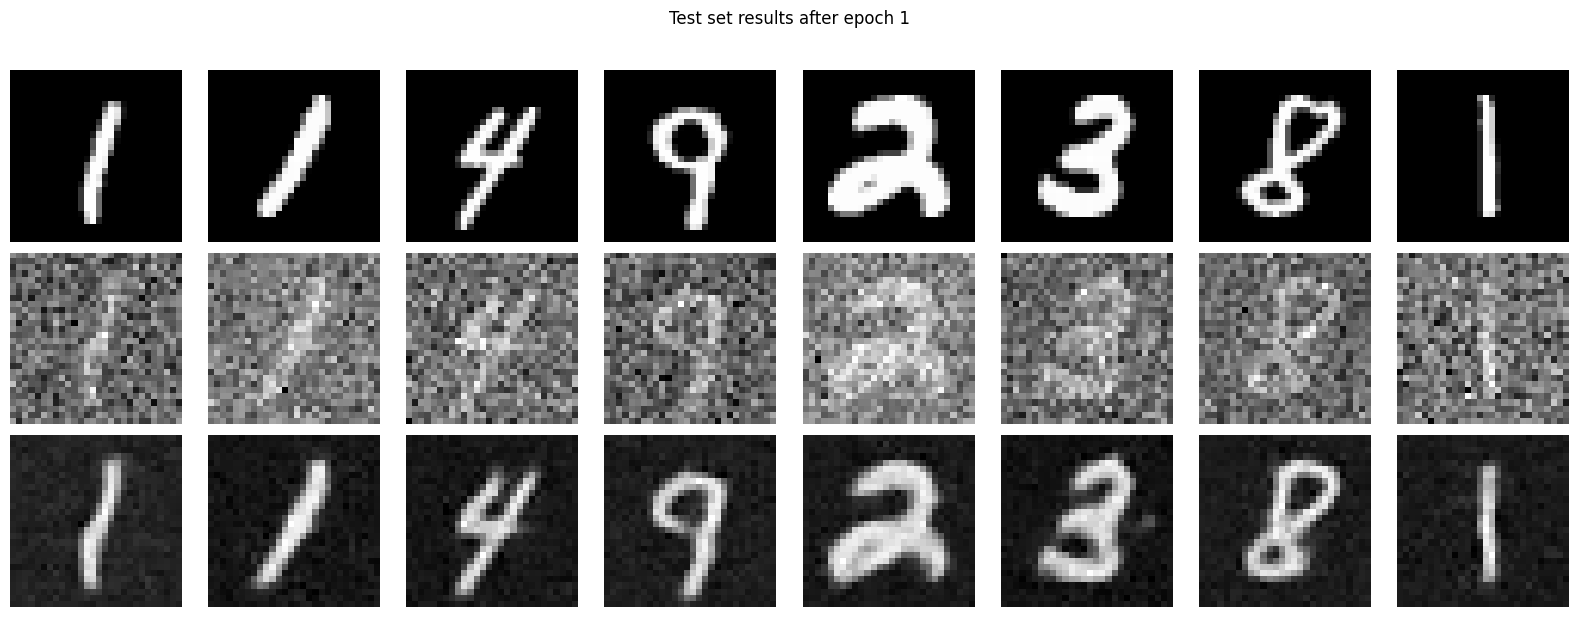

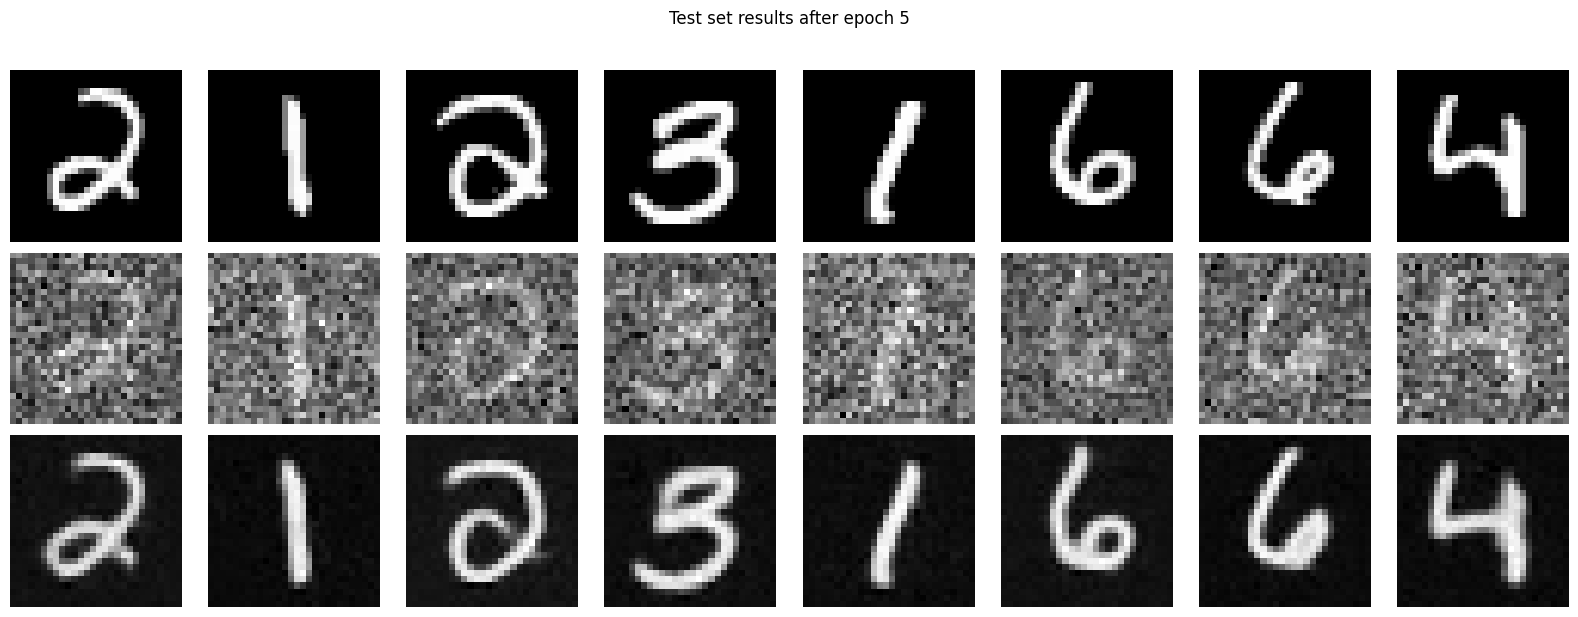

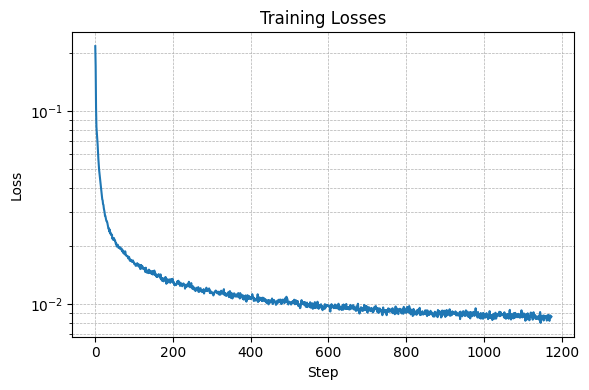

In [6]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# TODO
test_dataset = MNIST(root = 'data', download = True, transform = ToTensor(), train = False)
test_loader  = DataLoader(test_dataset, batch_size = 8, shuffle = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UnconditionalUNet(1, 128).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()
train_losses = []
for epoch in range(1, 6):
    model.train()
    for x, _ in dataloader:
        x = x.to(device)
        z = x + 0.5 * torch.randn_like(x)
        pred = model(z)
        loss = criterion(pred, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    if epoch in (1, 5):
        model.eval()
        xt, _ = next(iter(test_loader))
        xt = xt.to(device)
        zt = xt + 0.5 * torch.randn_like(xt)
        with torch.no_grad():
            xd = model(zt).cpu()
        fig, axes = plt.subplots(3, xt.size(0), figsize = (xt.size(0) * 2, 6))
        for i in range(xt.size(0)):
            axes[0,i].imshow(xt[i, 0].cpu(), cmap = 'gray'); axes[0, i].axis('off')
            axes[1,i].imshow(zt[i, 0].cpu(), cmap = 'gray'); axes[1, i].axis('off')
            axes[2,i].imshow(xd[i, 0], cmap = 'gray'); axes[2, i].axis('off')
        axes[0, 0].set_ylabel("Input")
        axes[1, 0].set_ylabel(f"Noisy (σ={0.5})")
        axes[2, 0].set_ylabel("Denoised")
        plt.suptitle(f"Test set results after epoch {epoch}", y = 1.02)
        plt.tight_layout()
        plt.show()
plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.yscale('log')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(f"Training Losses")
plt.grid(which = 'both', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.show()

## Out-of-Distribution Testing

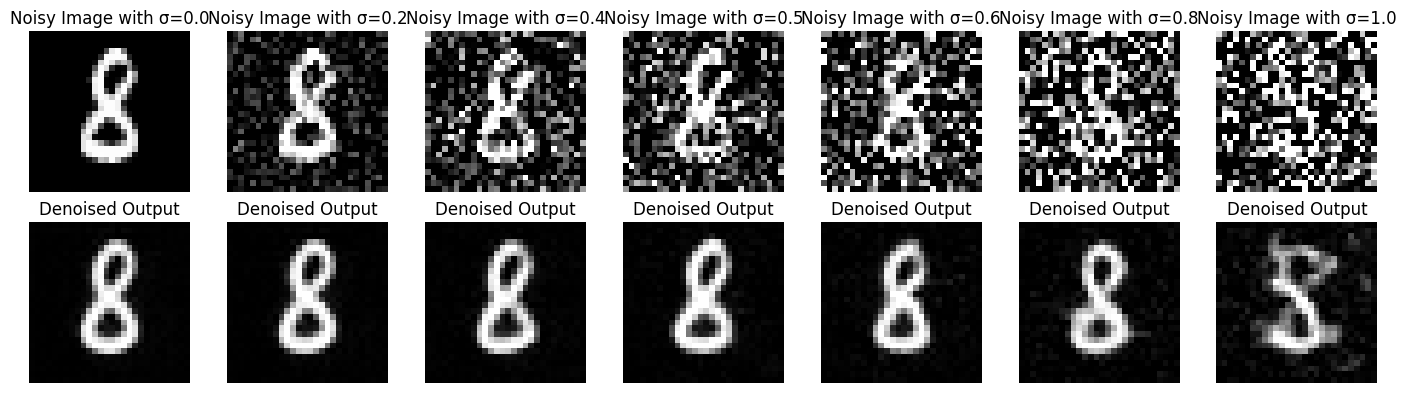

In [7]:
# TODO
model.eval()
xt, _ = next(iter(test_loader))
x0 = xt[0:1].to(device)
l = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
fig, axes = plt.subplots(2, len(l), figsize = (2 * len(l), 4))
with torch.no_grad():
    for i, j in enumerate(l):
        z = x0 + j * torch.randn_like(x0)
        out = model(z).cpu()
        axes[0, i].imshow(z[0, 0].cpu(), cmap = "gray", vmin = 0, vmax = 1)
        axes[0, i].set_title(f"Noisy Image with σ={j:.1f}")
        axes[0, i].axis("off")
        axes[1, i].imshow(out[0, 0], cmap = "gray", vmin = 0, vmax = 1)
        axes[1, i].set_title("Denoised Output")
        axes[1, i].axis("off")
plt.tight_layout()
plt.show()

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [8]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.l1 = nn.Linear(in_channels, out_channels)
        self.l2 = nn.GELU()
        self.l3 = nn.Linear(out_channels, out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.D = num_hiddens
        self.in_channels = in_channels
        self.op1 = ConvBlock(in_channels, num_hiddens)
        self.op2 = DownBlock(num_hiddens, 2 * num_hiddens)
        self.op3 = DownBlock(2 * num_hiddens, 4 * num_hiddens)
        self.op4 = Flatten()
        self.op5 = Unflatten(4 * num_hiddens)
        self.op6 = FCBlock(1, 4 * num_hiddens)
        self.op7 = FCBlock(1, 2 * num_hiddens)
        self.op8 = UpBlock(4 * num_hiddens, 2 * num_hiddens)
        self.op9 = UpBlock(4 * num_hiddens, num_hiddens)
        self.op10 = nn.Conv2d(2 * num_hiddens, in_channels, 1)
    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        e0 = self.op1(x)
        e1 = self.op2(e0)
        e2 = self.op3(e1)
        f = self.op4(e2)
        t0 = t.unsqueeze(-1)
        t0 = self.op6(t0).view(-1, 4 * self.D, 1, 1)
        f += t0
        d0 = self.op5(f)
        d1 = self.op8(d0)
        t1 = t.unsqueeze(-1)
        t1 = self.op7(t1).view(-1, 2 * self.D, 1, 1)
        d1 += t1
        d2 = torch.cat([d1, e1], dim = 1)
        d3 = self.op9(d2)
        d3 = torch.cat([d3, e0], dim = 1)
        return self.op10(d3)

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [9]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim = 0)
    return {'betas': nn.Parameter(betas, requires_grad = False), 'alphas': nn.Parameter(alphas, requires_grad = False), 'alpha_bars': nn.Parameter(alpha_bars, requires_grad = False)}

In [15]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    # unet.train()
    # YOUR CODE HERE.
    device = x_0.device
    alpha_bars = ddpm_schedule["alpha_bars"]
    t = torch.randint(0, num_ts, (x_0.size(0),), device = device)
    abt = alpha_bars[t].view(x_0.size(0), 1, 1, 1)
    epsilon = torch.randn_like(x_0)
    xt = abt.sqrt() * x_0 + (1 - abt).sqrt() * epsilon
    eps_pred = unet(xt, t.float() / (num_ts - 1))
    return F.mse_loss(eps_pred, epsilon)

In [16]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    # unet.eval()
    # YOUR CODE HERE.
    torch.manual_seed(seed)
    device = next(unet.parameters()).device
    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alpha_bars = ddpm_schedule["alpha_bars"]
    xt = torch.randn((1, unet.in_channels, *img_wh), device = device)
    for t in reversed(range(num_ts)):
        z = torch.randn_like(xt) if t > 0 else torch.zeros_like(xt)
        beta = betas[t]
        alpha = alphas[t]
        alb = alpha_bars[t]
        atmp = alpha_bars[t - 1] if t > 0 else torch.tensor(1, device = device)
        ts = torch.full((1,), t, device = device, dtype = torch.float32) / (num_ts - 1)
        et = unet(xt, ts)
        x0 = (xt - (1 - alb).sqrt() * et) / alb.sqrt()
        xt = (atmp * beta / (1 - alb)).sqrt() * x0 + (alpha * (1 - atmp) / (1 - alb)).sqrt() * xt + beta.sqrt() * z
    return xt

In [12]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

## Training the Time-conditioned UNet

- Plot the loss curve
- Sample results on the test set

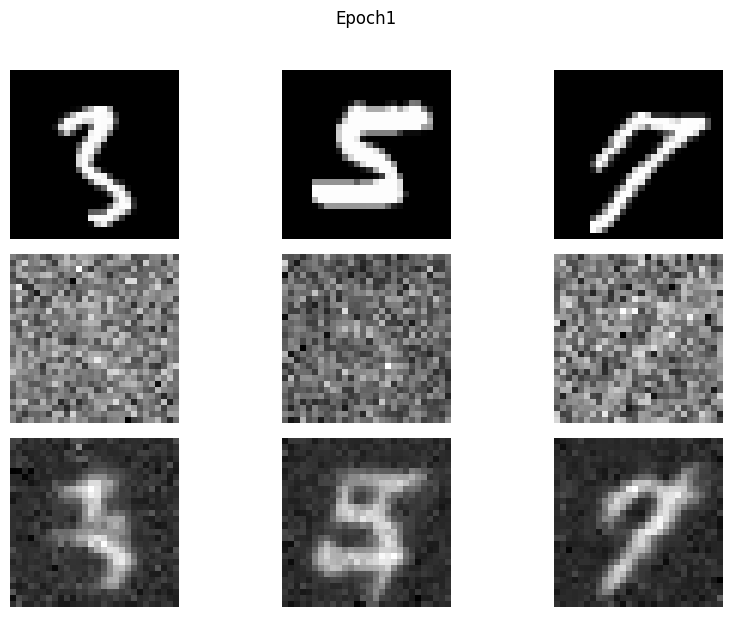

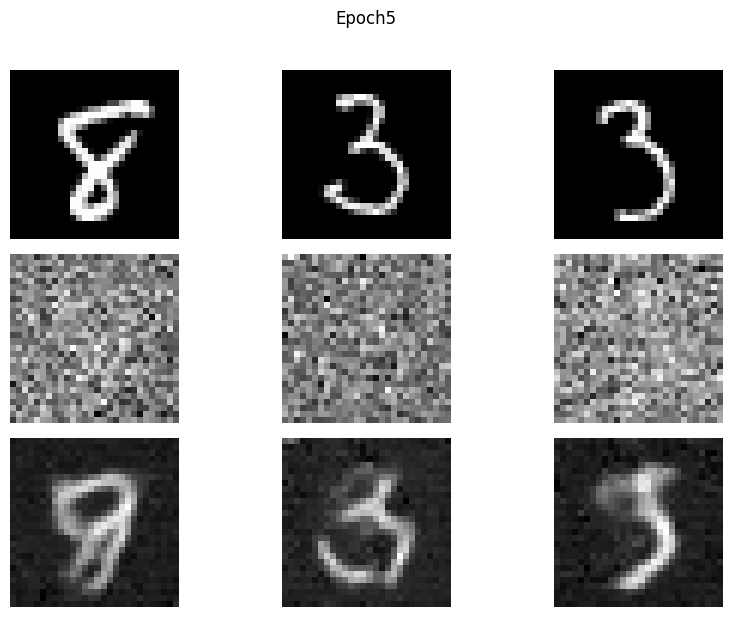

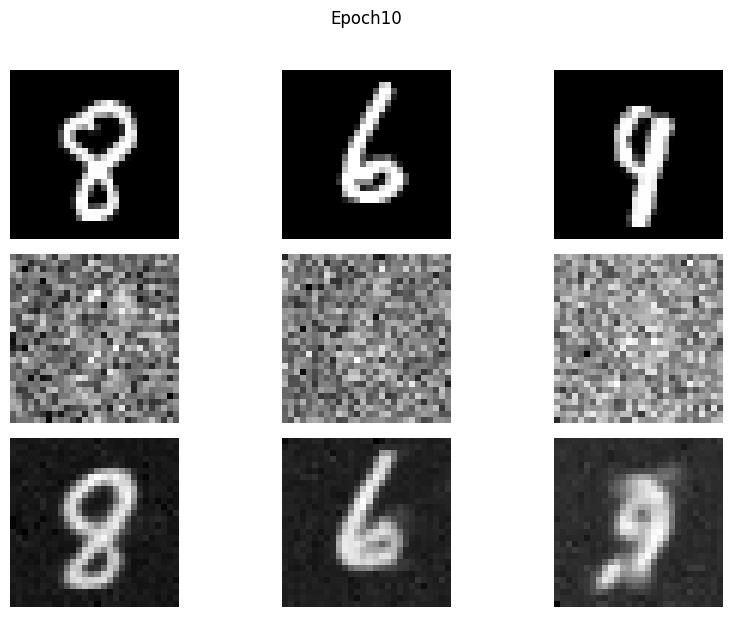

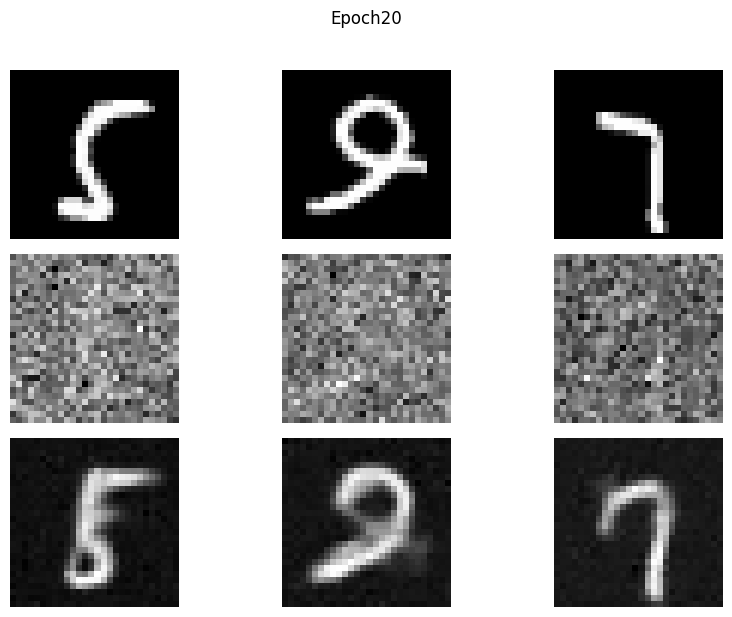

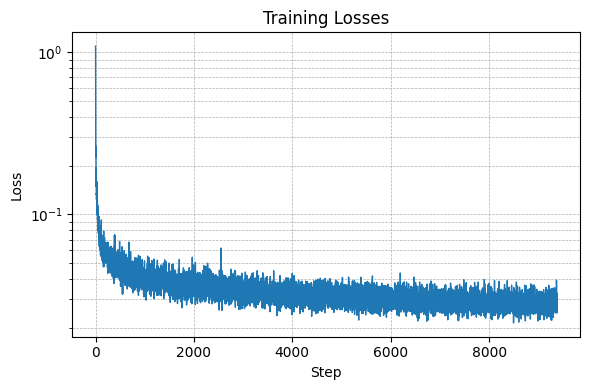

In [17]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO
test_ds = MNIST(root='data', download = True, transform = ToTensor(), train = False)
test_loader = DataLoader(test_ds, batch_size = 3, shuffle = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = TimeConditionalUNet(1, 1, 64).to(device)
ddpm = DDPM(unet).to(device)
optimizer = optim.Adam(ddpm.parameters())
s = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1 ** (1.0 / 20))
train_losses = []
for epoch in range(1, 21):
    ddpm.train()
    for x, _ in dataloader:
        x = x.to(device)
        loss = ddpm(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    s.step()
    if epoch in (1, 5, 10, 20):
        ddpm.eval()
        x0, _ = next(iter(test_loader))
        x0 = x0.to(device)
        alb = ddpm.ddpm_schedule["alpha_bars"][ddpm.num_ts // 2]
        alb = alb.view(1, 1, 1, 1)
        xt = alb.sqrt() * x0 + (1 - alb).sqrt() * torch.randn_like(x0)
        t = torch.full((x0.size(0),), ddpm.num_ts // 2, device = device, dtype = torch.float32) / (ddpm.num_ts - 1)
        with torch.no_grad():
            eps = unet(xt, t)
            xh = (xt - (1 - alb).sqrt() * eps) / alb.sqrt()
        fig, axes = plt.subplots(3, 3, figsize=(9, 6))
        for i in range(3):
            axes[0, i].imshow(x0[i, 0].cpu(), cmap = 'gray'); axes[0, i].axis('off')
            axes[1, i].imshow(xt[i, 0].cpu(), cmap = 'gray'); axes[1, i].axis('off')
            axes[2, i].imshow(xh[i, 0].cpu(), cmap = 'gray'); axes[2, i].axis('off')
        axes[0, 0].set_ylabel("Clean")
        axes[1, 0].set_ylabel(f"Noisy (t={ddpm.num_ts // 2})")
        axes[2, 0].set_ylabel("Reconstructed")
        plt.suptitle(f"Epoch{epoch}", y = 1.02)
        plt.tight_layout()
        plt.show()
plt.figure(figsize = (6, 4))
plt.plot(train_losses, linewidth = 1)
plt.yscale('log')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(which = "both", linestyle = "--", linewidth = 0.5)
plt.tight_layout()
plt.show()

### Implementing class-conditioned UNet

In [38]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.op1 = ConvBlock(in_channels, num_hiddens)
        self.op2 = DownBlock(num_hiddens, 2 * num_hiddens)
        self.op3 = DownBlock(2 * num_hiddens, 4 * num_hiddens)
        self.op4 = Flatten()
        self.op5 = Unflatten(4 * num_hiddens)
        self.op6 = FCBlock(1, 4 * num_hiddens)
        self.op7 = FCBlock(num_classes, 4 * num_hiddens)
        self.op8 = FCBlock(1, 2 * num_hiddens)
        self.op9 = FCBlock(num_classes, 2 * num_hiddens)
        self.op10 = UpBlock(4 * num_hiddens, 2 * num_hiddens)
        self.op11 = UpBlock(4 * num_hiddens, num_hiddens)
        self.op12 = nn.Conv2d(2 * num_hiddens, in_channels, 1)
    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        e0 = self.op1(x)
        e1 = self.op2(e0)
        e2 = self.op3(e1)
        f = self.op4(e2)
        t0 = self.op6(t.unsqueeze(-1))
        t0 = t0.view(x.size(0), -1, 1, 1)
        c0 = F.one_hot(c, self.num_classes).float().to(x.device)
        if mask is not None:
            c0 = c0 * mask.unsqueeze(-1).float()
        c1 = self.op7(c0)
        c1 = c1.view(x.size(0), -1, 1, 1)
        f += t0 + c1
        u = self.op5(f)
        u0 = self.op10(u)
        t1 = self.op8(t.unsqueeze(-1)).view(x.size(0), -1, 1, 1)
        c2 = self.op9(c0).view(x.size(0), -1, 1, 1)
        u0 += t1 + c2
        u0 = torch.cat([u0, e1], dim = 1)
        u1 = self.op11(u0)
        u1 = torch.cat([u1, e0], dim = 1)
        return self.op12(u1)

In [26]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    # unet.train()
    # YOUR CODE HERE.
    device = x_0.device
    betas = ddpm_schedule["betas"]
    alphas_bars = ddpm_schedule["alpha_bars"]
    t = torch.randint(0, num_ts, (x_0.size(0),), device = device)
    abt = alphas_bars[t].view(x_0.size(0), 1, 1, 1)
    e = torch.randn_like(x_0)
    xt = abt.sqrt() * x_0 + (1 - abt).sqrt() * e
    tn = t.float() / (num_ts - 1)
    mask = (torch.rand(x_0.size(0), device = device) > p_uncond).to(device)
    return F.mse_loss(unet(xt, c, tn, mask), e)

In [28]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    # unet.eval()
    # YOUR CODE HERE.
    torch.manual_seed(seed)
    device = next(unet.parameters()).device
    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alphas_bars = ddpm_schedule["alpha_bars"]
    xt = torch.randn((c.size(0), unet.in_channels, *img_wh), device = device)
    for t in reversed(range(num_ts)):
        if t > 0:
            z = torch.randn_like(xt)
        else:
            z = torch.zeros_like(xt)
        bt = betas[t]
        at = alphas[t]
        abt = alphas_bars[t]
        abt1 = alphas_bars[t - 1] if t > 0 else torch.tensor(1, device = device)
        tn = torch.full((c.size(0),), t, device = device, dtype = torch.float32) / (num_ts - 1)
        epu = unet(xt, c, tn, torch.zeros(c.size(0), device = device))
        epc = unet(xt, c, tn, torch.ones(c.size(0), device = device))
        e = (epc - epu) * guidance_scale + epu
        xh = (xt - (1 - abt).sqrt() * e) / abt.sqrt()
        xt = xh * (abt1 * bt / (1 - abt)).sqrt() + xt * (at * (1 - abt1) / (1 - abt)).sqrt() + z * bt.sqrt()
        return xt

In [30]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

## Training the Class-conditioned UNet

- Plot the loss curve
- Sample results on the test set

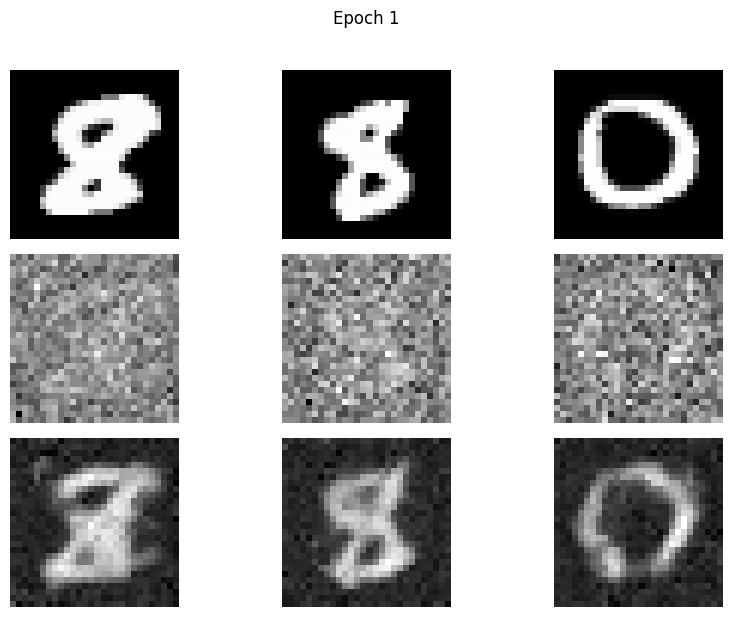

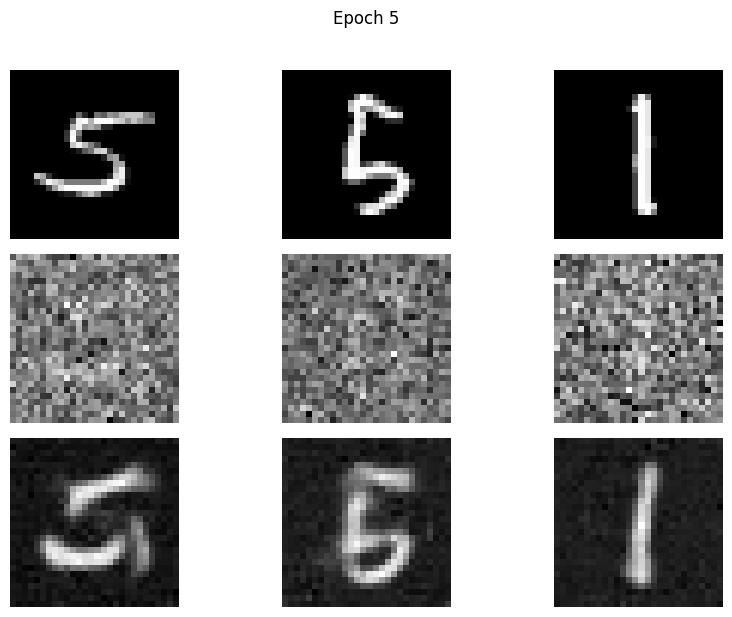

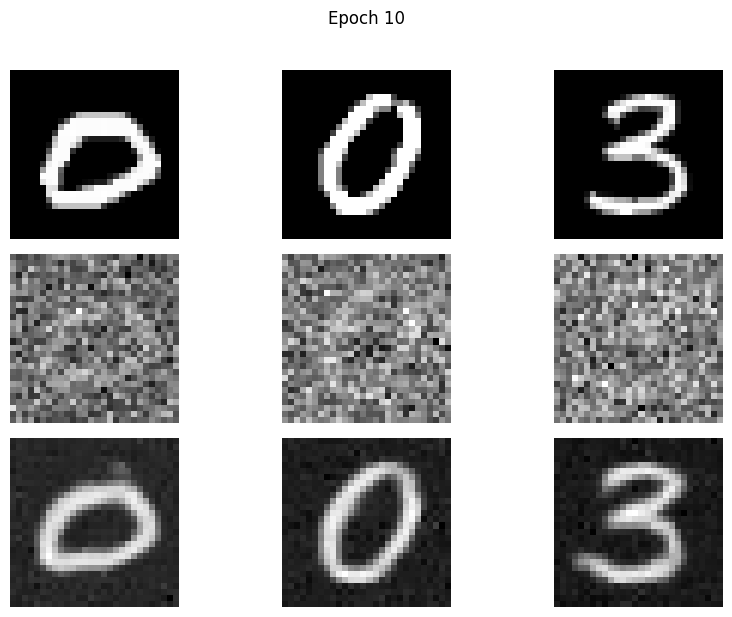

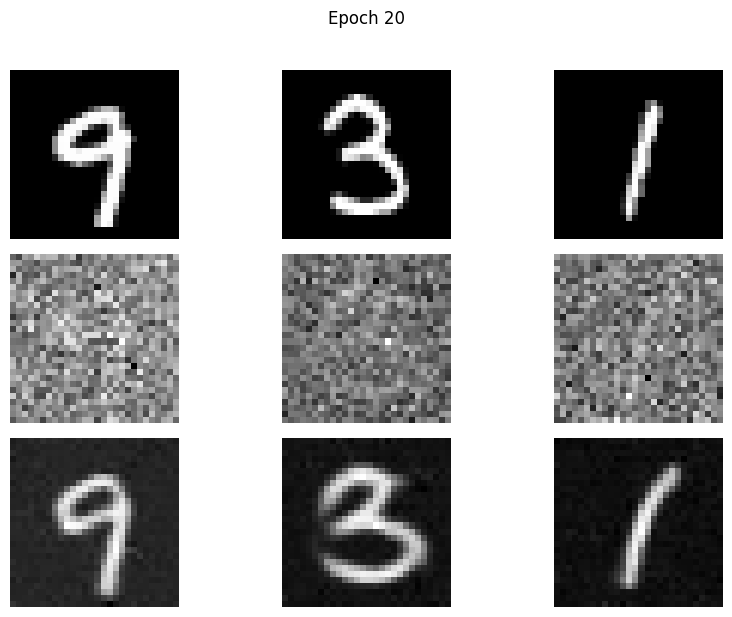

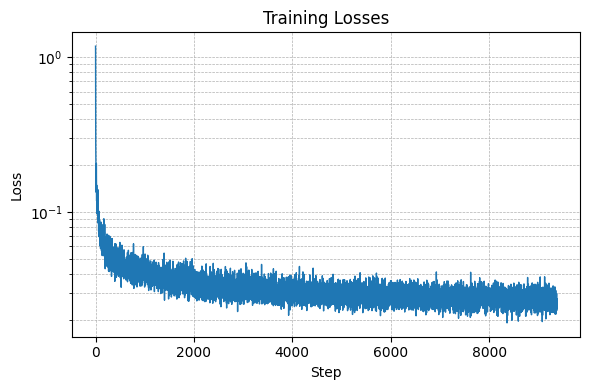

In [42]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO
test_ds = MNIST(root = 'data', download = True, transform = ToTensor(), train = False)
test_loader = DataLoader(test_ds, batch_size = 3, shuffle = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = ClassConditionalUNet(1, 10, 64).to(device)
ddpm = DDPM(unet).to(device)
optimizer = optim.Adam(ddpm.parameters(), lr = 1e-3)
s = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1 ** (1.0 / 20))
train_losses = []
for epoch in range(1, 21):
    ddpm.train()
    for x, labels in dataloader:
        x, labels = x.to(device), labels.to(device)
        loss = ddpm(x, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    s.step()
    if epoch in (1, 5, 10, 20):
        ddpm.eval()
        x0, c0 = next(iter(test_loader))
        x0, c0 = x0.to(device), c0.to(device)
        a_bar = ddpm.ddpm_schedule["alpha_bars"][ddpm.num_ts // 2]
        a_bar = a_bar.view(1, 1, 1, 1).to(device)
        xt = a_bar.sqrt() * x0 + (1 - a_bar).sqrt() * torch.randn_like(x0)
        tn = torch.full((x0.size(0),), ddpm.num_ts // 2, device = device, dtype = torch.float32) / (ddpm.num_ts - 1)
        with torch.no_grad():
            xh = (xt - (1 - a_bar).sqrt() * unet(xt, c0, tn)) / a_bar.sqrt()
        fig, axes = plt.subplots(3, 3, figsize = (9, 6))
        for i in range(3):
            axes[0, i].imshow(x0[i, 0].cpu(), cmap = 'gray')
            axes[1, i].imshow(xt[i,  0].cpu(), cmap = 'gray')
            axes[2, i].imshow(xh[i,0].cpu(), cmap = 'gray')
            for ax in axes[:, i]:
                ax.axis('off')
        axes[0, 0].set_ylabel("Clean")
        axes[1, 0].set_ylabel(f"Noisy (t={ddpm.num_ts // 2})")
        axes[2, 0].set_ylabel("Reconstructed")
        plt.suptitle(f"Epoch {epoch}", y = 1.02)
        plt.tight_layout()
        plt.show()
        ddpm.train()
plt.figure(figsize=(6, 4))
plt.plot(train_losses, linewidth = 1)
plt.yscale('log')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.grid(which = 'both', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.show()